<center>
    <img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" height="400" width="800">
</center>  

# Yet another math for DS course: домашнее задание 2

**ФИО:** Карагодин Никита Сергеевич

**Социальный бонус [1 балл]:** у нас онлайн-магистратура, но это не отменяет движа. Сходите куда-нибудь с однокурсниками и прикрепите фото с этого похода сюда.

## Общая информация


__Дата выдачи:__ 18.10.2023

__Мягкий дедлайн:__ 23:59MSK 19.11.2023

__Жёсткий дедлайн:__ 23:59MSK 26.11.2023

## Формат сдачи

Сам ноутбук называйте в формате hw-02-USERNAME.ipynb, где USERNAME — ваши фамилия и имя. Файл надо будет сдать в anytask.

## Оформление

1. Be good, drink milk and [think of Russia](https://www.youtube.com/watch?v=jyxSFfBKMxQ)
2. Обязательно фиксируйте зерно генератора случайных чисел в экспериментах. При перезапуске кода значения не должны меняться.
3. Вверху файла подпишите фамилию, имя, группу и какой-то занимательный факт о себе.
4. Обратите внимание, что у графиков должны быть подписаны оси, заголовок графика и при необходимости обязательно наличие легенды.

> За отсутствие названий графиков и подписей к осям могут снижаться баллы. Все картинки должны быть самодостаточны и визуально удобны для восприятия, так чтобы не нужно было смотреть ваш код или знать задание, чтобы понять что на них изображено.


Для каждого построенного графика делайте выводы. Эти выводы не должны быть поверхностными и очевидными. Не будьте мудрым королём.

<br>

<center>
<img src="https://raw.githubusercontent.com/hse-econ-data-science/andan_2023/main/hw/king.png" width="300">
</center>

**Пример плохого вывода:** Синенькая линия идет вверх, а красная вниз. Черненькая идет вниз, а потом вверх.

<br>

<center>
<img src="https://raw.githubusercontent.com/hse-econ-data-science/andan_2023/main/hw/bad_lines.png" width="600">
</center>

In [1]:
import os

import numpy as np
import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

from IPython.display import display, Math
import torch
from scipy.linalg import lu, qr
import plotly.express as px
from scipy.signal import convolve2d
from scipy.ndimage import convolve1d

from timeit import timeit
import plotly.graph_objects as go
import timeit
from scipy.sparse import coo_matrix, dok_matrix, lil_matrix, csr_matrix, csc_matrix


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Часть 1: точность вычислений

## [20 баллов] Задача №1: точность вычислений

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность.

Для $LU$ разложения $l_2$-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

__[5 баллов] Задание 1.1__ Рассмотрим следующее LU-разложение:

$$
\begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}
\cdot
\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}
$$
и
$$
\begin{pmatrix}
1. & 0.\\
10.^{20} & 1.
\end{pmatrix}
\cdot
\begin{pmatrix}
10.^{-20} & 1.\\
0. & 1. - 10.^{20}
\end{pmatrix}
$$

Во втором случае мы специально указали Питону (поставив везде десятичные точки), что хотим работать не с целыми числами, а с числами с плавающей точкой. Перемножьте полученные матрицы $L$ и $U$. Как ответ вам кажется правильным, почему?

Давайте посчитаем!

In [6]:
# Целочисленный тип
L = np.array([[1, 0], [10**20, 1]])
U = np.array([[10**-20, 1], [0, 1-10**20]])
np.dot(L, U)

array([[1e-20, 1],
       [1.0, 1]], dtype=object)

In [7]:
# Тип float
L = np.array([[1., 0.], [1e20, 1.]])
U = np.array([[10.**-20, 1.], [0., 1. -10.**20]])
np.dot(L, U)

array([[1.e-20, 1.e+00],
       [1.e+00, 0.e+00]])

Видим различия в элементе [1,1]. Если посчитать ручками, то правльный ответ выдает формат int. Why?

> __Ответ:__ Важно помнить, что тип float в Python ограничен, а вот int может принимать любые целочисленные значения (а то получится как здесь $\rightarrow$ https://ru.wikipedia.org/wiki/Авария_ракеты-носителя_«Ариан-5»_(4_июня_1996_года))

Это происходит потому, что как число $10^{20}$ превышает целочисленные пределы представления C double (это то, в терминах чего реализован Python float).

Обычно C double представляют собой двоичные числа с плавающей точкой стандарта IEEE 754 с 64 битами, что означает, что они имеют 53 бита целочисленной точности (последние последовательные целые значения, которые float может представить, это 2 ** 53 - 1, за которым следует 2 ** 53; он не может представить 2 ** 53 + 1). Проблема в том, что $10^{20}$ требует 67 бит целочисленной точности для хранения:

In [52]:
(10**20).bit_length()

67

Когда значение слишком велико для мантиссы (целочисленной составляющей), то экспоненциальная составляющая числа с плавающей точкой используется для масштабирования меньшего целого значения степенями 2, чтобы быть примерно в районе исходного значения, но это означает, что представимые целые числа начинают пропускать, сначала по 2 (так как вам нужно больше 53 бит), затем по 4 (для больше 54 бит), затем по 8 (больше 55 бит), затем по 16 (больше 56 бит) и т.д., пропуская в два раза больше между представимыми значениями для каждого бита величины, которую вы не можете представить в 53 битах.

То есть в нашем случае в элементе $1-10^{20}$ единица остается незаметной:( Из-за этого происходят такие проблемы...

Поэтому правильный вариант для вычисления прозведения - это матрица с целыми числами.

Отметим, что в реальных вычислениях матричные элементы почти наверняка с самого начала будут числами с плавающей точкой (а не целыми).

**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$
Это число называется *фактором роста матрицы*.

Но что, если это отношение велико? (Это может привести к большим ошибкам округления и потере точности)

__[5 баллов] Задание 1.2__  Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, вы можете сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [76]:
size = 500
A = np.zeros((size, size))

for i in range(size):
    for j in range(size):
        if i == j or j == size - 1:
            A[i, j] = 1
        elif i > j:
            A[i, j] = -1
A

array([[ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [-1.,  1.,  0., ...,  0.,  0.,  1.],
       [-1., -1.,  1., ...,  0.,  0.,  1.],
       ...,
       [-1., -1., -1., ...,  1.,  0.,  1.],
       [-1., -1., -1., ..., -1.,  1.,  1.],
       [-1., -1., -1., ..., -1., -1.,  1.]])

In [77]:
P, L, U = lu(A)

# Сделаем единичную матрицу размера матрицы P - np.eye(len(P)) и проверим на равенство
if np.array_equal(P, np.eye(len(P))):
    print("Матрица P является единичной.")
else:
    print("Матрица P не является единичной.")

Матрица P является единичной.


In [78]:
# QR разложение
Q, R = qr(A)
np.allclose(A, np.dot(Q, R))

True

In [79]:
# Вычисляем норму разности A и LU
norm_LU = np.linalg.norm(A - L @ U, ord=2)
display(Math(r'$||A - LU||_2 = $'), norm_LU)
# Вычисляем норму разности A и QR
norm_QR = np.linalg.norm(A - Q @ R, ord=2)
display(Math(r'$||A - QR||_2 = $'), norm_QR)


<IPython.core.display.Math object>

5.0768322940305e+114

<IPython.core.display.Math object>

6.559826447788776e-13

Фактор роста матрицы:$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|},$$

где $u_{ij}$ - элементы матрицы $U$, а $a_{ij}$ - элементы матрицы $A$.

In [80]:
# Вычисляем максимальный модуль элемента матрицы U
max_U = np.max(np.abs(U))
# Вычисляем максимальный модуль элемента матрицы A
max_A = np.max(np.abs(A))
rho = max_U / max_A
rho

224.85631181451922

К счастью, на практике так редко очень бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

__[5 баллов] Задание 1.3__  Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?

> __Ответ:__ 

Матрицу Паскаля $S_n$ можно представить в виде произведения двух треугольных матриц $L_n$ и $U_n$:$$S_n=L_nU_n,$$
где

$ L_{ij} =
\begin{cases}
C_i^j = \frac{i!}{j!(i-j)!}, &  i \geq j \\
0, & i < j
\end{cases}$


$U_{i,j} =
\begin{cases}
C_j^i = \frac{j!}{i!(j-i)!}, & i \leq j \\
0, & i > j
\end{cases}
$ 

Мини-обоснование:

- Можно показать, что произведение LU дает матрицу Паскаля, используя свойство биномиальных коэффициентов: $C_n^k=C_{n−1}^{k−1}+C_{n−1}^k$.

Так как $L$ и $U$ - треугольные матрицы, то их определители равны произведению их диагональных элементов, которые в данном случае все равны единице:

$ \det(L) = 1$, $ \det(U) = 1$

Отсюда следует, что $\det(S_n)=1$

__[5 баллов] Задание 1.4__ Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

In [2]:
def my_pascal(n):
    return sla.pascal(n)

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [82]:
A = my_pascal(10)
P, L, U = lu(A)
np.linalg.norm(A - P @ L @ U, 2)

6.164262559385983e-12

Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [83]:
A = my_pascal(30)
print('determinant: ', sla.det(A))
# Try to solve a linear system
x = np.ones(30)
b = A.dot(x).reshape(30, 1) # для linalg.solve из scipy
x1 = sla.solve(A, b)
print('residual: ', sla.norm(x1 - x))

determinant:  -3.400444993542751e+51
residual:  303300758.1003645


C:\Users\huawei\AppData\Local\Temp\ipykernel_16092\241312460.py:6: LinAlgWarning: Ill-conditioned matrix (rcond=5.99862e-25): result may not be accurate.
  x1 = sla.solve(A, b)


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [84]:
Q, R = np.linalg.qr(A)
# Определитель матрицы Паскаля равен произведению диагональных элементов матрицы R
det = np.prod(np.diag(R))
det

-1.321655894306895e+46

Объясните полученные неприятные результаты.

In [86]:
# Найдем число обусловленности матрицы А
np.linalg.cond(A)

4.278134328743199e+24

Еще одно замечание касается числовых эквивалентов выражений «близко к 1» и «значительно превышает 1». Понятно, что эти выражения субъективны и зависят от требований к точности представлений исходных данных и вычислений в конкретно решаемой задаче. Принято считать $cond(A) \leq 10 $ хорошим числом, а $cond(A)\geq 1000$ — плохим числом. Но это всё — условности.

У нас просто гигантское число!

> __Ответ:__ Матрица Паскаля является очень плохо обусловленной матрицей. Это означает, что малые изменения в правой части системы или в элементах матрицы могут привести к большим изменениям в решении. Поэтому методы, основанные на LU- или QR-разложении, не могут дать точного решения для такой системы, так как они чувствительны к ошибкам округления. Видно, что определитель матрицы Паскаля очень большой по модулю, что свидетельствует о ее плохой обусловленности.

## [20 баллов] Задача №2:  решение СЛАУ

Реализуйте несколько алгоритмов решения СЛАУ $Ax = B$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $B$.

1. **Наивный способ**: $x = A^{-1}B$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [3]:
def naive_solve(A, B):
    return np.dot(np.linalg.inv(A), B)

def standard_solve(A, B):
    return solve(A, B)

def noscipy_cho_solve(A, B):
    # Разложение Холецкого
    L = np.linalg.cholesky(A)
    # Решение СЛАУ L * y = B
    y = solve_triangular(L, B, lower=True)
    # Решение СЛАУ L.T * x = y
    return solve_triangular(L.T, y)

def scipy_cho_solve(A, B):
    L, lower = cho_factor(A)
    return cho_solve((L, lower), B)

In [ ]:
a = np.array([[3, 1],[1, 2]])
b = np.array([9, 8])
naive_solve(a,b)

__[10 баллов] Задание 2.1__ Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

Одно из свойств положительно определенных матриц - все их собсвенные значения $\lambda_i> 0$. Воспользуемся этим фактом для их создания.

In [16]:
# Матрица А имеет размер n x n
def generate_positive_matrix(n):
    matrix = np.random.randn(n, n)
    return matrix @ matrix.T

# Матрица B имеет размер n x m
def generate_matrix(n, m):
    matrix = np.random.randn(n,m)
    return matrix

A1 = generate_positive_matrix(10)
B1 = generate_matrix(10, 10)

A2 = generate_positive_matrix(100)
B2 = generate_matrix(100, 10)

In [26]:
# Сравнвиаем на равенство
np.allclose(naive_solve(A1, B1), standard_solve(A1,B1))
np.allclose(standard_solve(A1,B1), noscipy_cho_solve(A1,B1))
np.allclose(noscipy_cho_solve(A1,B1), scipy_cho_solve(A1,B1))

True

In [27]:
np.allclose(naive_solve(A2, B2), standard_solve(A2,B2))
np.allclose(standard_solve(A2,B2), noscipy_cho_solve(A2,B2))
np.allclose(noscipy_cho_solve(A2,B2), scipy_cho_solve(A2,B2))

True

__[10 баллов] Задание 2.2__ Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

In [ ]:
def time_solve(n, m):
    matrix = np.random.randn(n, n)
    A = matrix @ matrix.T
    B = np.random.randn(n, m)
    number = 100

    def naive_solve():
        return np.dot(np.linalg.inv(A), B)

    def standard_solve():
        return linalg.solve(A, B)

    def noscipy_cho_solve():
        # Разложение Холецкого
        L = np.linalg.cholesky(A)
        # Решение СЛАУ L * y = B
        y = solve_triangular(L, B, lower=True)
        # Решение СЛАУ L.T * x = y
        return solve_triangular(L.T, y)

    def scipy_cho_solve():
        L, lower = cho_factor(A)
        return cho_solve((L, lower), B)
    
    return timeit.timeit(naive_solve, number=number)/number, timeit.timeit(standard_solve, number=number)/number, timeit.timeit(noscipy_cho_solve, number=number)/number, timeit.timeit(scipy_cho_solve, number=number)/number

n_size = [i for i in range(100, 1000, 50)]
m_size = [i for i in [10,100,1000]]
times_naive = {}
times_standard = {}
times_noscipy_cho = {}
times_scipy_cho = {}

for m in tqdm(m_size):
    times_naive[f"m_size = {m}"] = []
    times_standard[f"m_size = {m}"] = []
    times_noscipy_cho[f"m_size = {m}"] = []
    times_scipy_cho[f"m_size = {m}"] = []
    for n in tqdm(n_size):
        time = time_solve(n, m)
        times_naive[f"m_size = {m}"].append(time[0])
        times_standard[f"m_size = {m}"].append(time[1])
        times_noscipy_cho[f"m_size = {m}"].append(time[2])
        times_scipy_cho[f"m_size = {m}"].append(time[3])

In [ ]:
import plotly.express as px
import pandas as pd
# Создание данных для графика
data = {'n_size': n_size,
        'times_naive': times_naive['m_size = 10'],
        'times_standard': times_standard['m_size = 10'],
        'times_noscipy_cho': times_noscipy_cho['m_size = 10'],
        'times_scipy_cho': times_scipy_cho['m_size = 10']}

# Создание DataFrame из данных
df = pd.DataFrame(data)

# Построение графика
fig = px.line(df, x='n_size', y=['times_naive', 'times_standard', 'times_noscipy_cho', 'times_scipy_cho'],
              labels={'n_size': 'Размер матрицы', 'value': 'Время решения СЛАУ (сек)'},
              title='Зависимость времени решения СЛАУ от размера матрицы А для m_size = 10',
              markers=True)
fig.show()

In [ ]:
data = {'n_size': n_size,
        'times_naive': times_naive['m_size = 100'],
        'times_standard': times_standard['m_size = 100'],
        'times_noscipy_cho': times_noscipy_cho['m_size = 100'],
        'times_scipy_cho': times_scipy_cho['m_size = 100']}

# Создание DataFrame из данных
df = pd.DataFrame(data)

# Построение графика
fig = px.line(df, x='n_size', y=['times_naive', 'times_standard', 'times_noscipy_cho', 'times_scipy_cho'],
              labels={'n_size': 'Размер матрицы', 'value': 'Время решения СЛАУ (сек)'},
              title='Зависимость времени решения СЛАУ от размера матрицы А для m_size = 100',
              markers=True)
fig.show()

In [ ]:
data = {'n_size': n_size,
        'times_naive': times_naive['m_size = 1000'],
        'times_standard': times_standard['m_size = 1000'],
        'times_noscipy_cho': times_noscipy_cho['m_size = 1000'],
        'times_scipy_cho': times_scipy_cho['m_size = 1000']}

# Создание DataFrame из данных
df = pd.DataFrame(data)

# Построение графика
fig = px.line(df, x='n_size', y=['times_naive', 'times_standard', 'times_noscipy_cho', 'times_scipy_cho'],
              labels={'n_size': 'Размер матрицы', 'value': 'Время решения СЛАУ (сек)'},
              title='Зависимость времени решения СЛАУ от размера матрицы А для m_size = 1000',
              markers=True)
fig.show()

Во всех 3 случаях быстрейшим оказалось решение СЛАУ с помощью разложения Холецкого с процедурами scipy.

Худшим же оказалось наивное решение, поскольку оно требует обращение матрицы A - а это операция с кубической сложностью по времени $O(n^3)$

Наивный способ требует $O(n^3)$ операций для нахождения $A^{−1}$ и $O(n^2m)$ операций для умножения на $B$, где $n$ — размер матрицы $A$, а $m$ — число столбцов матрицы $B$. Итого, мы получаем $O(n^3+n^2m)$ операций.

У алгоритма Гаусса схожая ассимптоическая сложность (отличия могут быть в коэффициентах).

Если матрица A симметрична и положительно определена, то мы можем использовать разложение Холецкого, которое требует только $O(n^3/3)$ операций для факторизации матрицы $A$ и $O(n^2m)$ операций для решения двух СЛАУ. Итого, мы получаем $O(n^3/3+n^2m)$ операций.

In [ ]:
n_size = 100
m_size = [i for i in range(100, 10000, 100)]
times_naive = {}
times_standard = {}
times_noscipy_cho = {}
times_scipy_cho = {}

for m in tqdm(m_size):
    times_naive[f"m_size = {m}"] = []
    times_standard[f"m_size = {m}"] = []
    times_noscipy_cho[f"m_size = {m}"] = []
    times_scipy_cho[f"m_size = {m}"] = []
    time = time_solve(n_size, m)
    times_naive[f"m_size = {m}"].append(time[0])
    times_standard[f"m_size = {m}"].append(time[1])
    times_noscipy_cho[f"m_size = {m}"].append(time[2])
    times_scipy_cho[f"m_size = {m}"].append(time[3])

In [ ]:
df = pd.DataFrame.from_dict(times_naive, orient='index', columns=['times_naive'])
df['times_standard'] = pd.DataFrame.from_dict(times_standard, orient='index')
df['times_noscipy_cho'] = pd.DataFrame.from_dict(times_noscipy_cho, orient='index')
df['times_scipy_cho'] = pd.DataFrame.from_dict(times_scipy_cho, orient='index')

df = df.reset_index().rename(columns={'index': 'm_size'})

fig = px.line(df, x='m_size', y=['times_naive', 'times_standard', 'times_noscipy_cho', 'times_scipy_cho'], 
              labels={'m_size': 'Размер матрицы', 'value': 'Время решения СЛАУ (сек)'},
              title='Зависимость времени решения СЛАУ от размера матрицы А',
              markers=True)
fig.show()

Здесь видна разница, так в как стандартном методе, разложении Холецкого и разложении Холецкого с процедурами scipy, число операций зависит от числа правых частей сильнее, так как они решают СЛАУ для каждой правой части отдельно. 

В результате получается, что наивный способ оказывается быстрее.

## [20 баллов] Задача №3: Разреженные матрицы

- [Вот здесь](http://docs.scipy.org/doc/scipy/reference/sparse.html) можно посмотреть, как различные форматы разреженных матриц реализованы в библиотеке `scipy`.
- [Вот здесь](https://www.cise.ufl.edu/research/sparse/matrices/index.html) выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.
- [Вот тут в туториале можно найти много полезных функций](https://matteding.github.io/2019/04/25/sparse-matrices/)

__[5 баллов] Задание 3.1__ Разные форматы разреженных матриц можно преобразовывать друг в друга. Преобразование из формата `LIL` в формат `CSR` занимает гораздо больше времени, чем преобразования между форматами `COO`, `CSR` и `CSC`. Почему так происходит?

## Рубрика "эксперменты".

In [8]:
np.random.seed(0)
def compare_sparse_matrix_conversions(n, m, density):
    # Generate a random sparse matrix of shape (n, m) and given density
    A = sp.random(n, m, density=density, format='coo')
    # Convert it to LIL format
    A_lil = A.tolil()
    # Define the conversion functions
    def lil_to_csr():
        return A_lil.tocsr()
    def coo_to_csr():
        return A.tocsr()
    # Measure the execution time of each function using timeit
    lil_time = timeit.timeit(lil_to_csr, number=100)/100
    coo_time = timeit.timeit(coo_to_csr, number=100)/100
    # Return the results as a tuple
    return (lil_time, coo_time)

# Определите список размеров матриц для тестирования
sizes = [100, 500, 1000, 5000, 10000]
# Определите фиксированную плотность
density = 0.1
# Инициализируйте пустые списки для хранения времени выполнения
lil_times = []
coo_times = []
# Цикл по размерам и сравните преобразования
for size in tqdm(sizes):
    lil_time, coo_time = compare_sparse_matrix_conversions(size, size, density)
    lil_times.append(lil_time)
    coo_times.append(coo_time)

# Создайте объект Figure с двумя линиями
fig = go.Figure()
fig.add_trace(go.Scatter(x=sizes, y=lil_times, mode='lines', name='LIL to CSR'))
fig.add_trace(go.Scatter(x=sizes, y=coo_times, mode='lines', name='COO to CSR'))

# Настройте оси и заголовок
fig.update_xaxes(title='Размер матрицы')
fig.update_yaxes(title='Время выполнения (с)')
fig.update_layout(title='Сравнение времени преобразования разреженных матриц')

# Покажите график
fig.show()

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
np.random.seed(0)
def compare_sparse_matrix_conversions(n, m, density):
    # Generate a random sparse matrix of shape (n, m) and given density
    A_lil = sp.random(n, m, density=density, format='lil')
    # Convert it to LIL format
    A = A_lil.tocoo()
    # Define the conversion functions
    def lil_to_csr():
        return A_lil.tocsr()
    def coo_to_csr():
        return A.tocsr()
    # Measure the execution time of each function using timeit
    lil_time = timeit.timeit(lil_to_csr, number=100)/100
    coo_time = timeit.timeit(coo_to_csr, number=100)/100
    # Return the results as a tuple
    return (lil_time, coo_time)

# Определите список размеров матриц для тестирования
sizes = [100, 500, 1000, 5000, 10000]
# Определите фиксированную плотность
density = 0.1
# Инициализируйте пустые списки для хранения времени выполнения
lil_times = []
coo_times = []
# Цикл по размерам и сравните преобразования
for size in tqdm(sizes):
    lil_time, coo_time = compare_sparse_matrix_conversions(size, size, density)
    lil_times.append(lil_time)
    coo_times.append(coo_time)

# Создайте объект Figure с двумя линиями
fig = go.Figure()
fig.add_trace(go.Scatter(x=sizes, y=lil_times, mode='lines', name='LIL to CSR'))
fig.add_trace(go.Scatter(x=sizes, y=coo_times, mode='lines', name='COO to CSR'))

# Настройте оси и заголовок
fig.update_xaxes(title='Размер матрицы')
fig.update_yaxes(title='Время выполнения (с)')
fig.update_layout(title='Сравнение времени преобразования разреженных матриц')

# Покажите график
fig.show()

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
np.random.seed(0)
def compare_sparse_matrix_conversions(n, m, density):
    # Generate a random sparse matrix of shape (n, m) and given density
    A_lil = sp.random(n, m, density=density, format='lil')
    # Convert it to LIL format
    A = A_lil.tocoo()
    # Define the conversion functions
    def lil_to_csc():
        return A_lil.tocsc()
    def coo_to_csc():
        return A.tocsc()
    # Measure the execution time of each function using timeit
    lil_time = timeit.timeit(lil_to_csc, number=100)/100
    coo_time = timeit.timeit(coo_to_csc, number=100)/100
    # Return the results as a tuple
    return (lil_time, coo_time)

sizes = [100, 500, 1000, 5000, 10000]
density = 0.1
lil_times = []
coo_times = []
for size in tqdm(sizes):
    lil_time, coo_time = compare_sparse_matrix_conversions(size, size, density)
    lil_times.append(lil_time)
    coo_times.append(coo_time)

fig = go.Figure()
fig.add_trace(go.Scatter(x=sizes, y=lil_times, mode='lines', name='LIL to CSC'))
fig.add_trace(go.Scatter(x=sizes, y=coo_times, mode='lines', name='COO to CSC'))

fig.update_xaxes(title='Размер матрицы')
fig.update_yaxes(title='Время выполнения (с)')
fig.update_layout(title='Сравнение времени преобразования разреженных матриц')
fig.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Из графика видно, что преобразование из формата LIL в формат CSC занимает больше времени, чем преобразование из формата COO в формат CSC, особенно при увеличении размера матрицы. Это объясняется тем, что формат LIL хранит данные в виде списков списков, а формат CSC - в виде "сжатых" столбцов. Для преобразования из LIL в CSC необходимо сортировать индексы строк и столбцов, а также перестраивать структуру данных, что требует больше времени. 

Формат COO хранит данные в виде трех массивов: значений, индексов строк и индексов столбцов. Для преобразования из COO в CSC достаточно отсортировать массивы по индексам столбцов и вычислить указатели на начало каждого столбца, что занимает меньше времени.

Однако наблюдаются отличия в 1 и 2 экспериментах. Предполагаю, что это связано с преобразованием в формат **tocsr**. В первом случае LIL отрабатывает быстрее, поскольку элменты уже отсторитрованы, а во 2 необходимо производить сортировку.

__[15 баллов] Задание 3.2__ Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою
таблицу со столбцами
* Номер записи
* *InvoiceNo* - номер чека
* *StockCode* - код товара
* *Description* - название товара

Чтобы понять, какие товары покупают вместе, вы решили построить (разреженную) матрицу, строки и столбцы которой соответствуют различным товарам, а в клетке с "номером" $(g_1, g_2)$ стоит число $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара.

Ниже приведён код, который вам нужно дополнить, дописав функцию ``CreateMatrix``, создающая из структуры pandas.DataFrame разреженную матрицу. Ваша реализация должна удовлетворять следующим свойствам:
* матрица должна создаваться эффективно и по возможности с минимальным числом циклов;
* итоговая матрица должна позволять быстро отвечать на следующие вопросы:
  - сколько всего было куплено товаров данного типа?
  - какие пары товаров покупались вместе чаще всего?
  - какие товары чаще всего покупались вместе с данным товаром?

Пожалуйста, объясните, почему вы выбрали именно ту, а не иную архитектуру.

> __Ответ:__ Вообще, существуют 5 основных архитектур разреженных матриц:

1. Coordinate Matrix (COO) - представляет матрицу как три одномерных массива: массив значений ненулевых элементов, массив индексов строк и массив индексов столбцов для каждого ненулевого элемента. Этот формат прост в использовании и подходит для создания больших матриц, так как он не требует сортировки или уникальности индексов. Однако, этот формат не поддерживает эффективные операции над матрицами, такие как сложение, умножение или нарезание, так как он не имеет информации о расположении элементов в матрице.

In [ ]:
coo = coo_matrix(([2, 5, 9, 1, 6], ([1, 3, 0, 2, 4], [1, 4, 2, 3, 3])), shape=(6, 7))
print(coo)  
coo.todense()

2. Dictionary of Keys Matrix (DOK) - представляет матрицу как хеш-таблицу, где ключами являются пары (индекс строки, индекс столбца), а значениями являются ненулевые элементы матрицы. Этот формат эффективен для установки элементов, так как он позволяет быстро проверять наличие или отсутствие элемента по ключу. Однако, этот формат не эффективен для доступа к элементам, так как он не гарантирует порядок или сортировку ключей. Также этот формат не поддерживает арифметические операции или нарезание матрицы.

In [ ]:
dok = dok_matrix((10, 10))
dok[(3, 7)] = 42
dok[(1, 9)] = 5
print(dok)

3. Linked List Matrix (LIL) - представляет матрицу как список списков, где каждый вложенный список содержит пары (индекс, значение) ненулевых элементов в соответствующей строке матрицы. Этот формат удобен для построения разреженных матриц инкрементально, то есть добавляя или изменяя элементы по одному или несколько за раз. Также этот формат поддерживает гибкое нарезание по строкам, то есть извлечение подматрицы по заданным индексам строк. Однако, этот формат не очень эффективен для арифметических операций и умножения матрицы на вектор, так как он требует много памяти и времени для обхода списков.

In [ ]:
lil = lil_matrix((6, 5), dtype=int)
lil[(0, -1)] = -1  # set individual point
lil[3, (0, 4)] = [-2] * 2  # set two points
print(lil)

4. Compressed Sparse Row (CSR) - представляет матрицу как три одномерных массива: массив значений ненулевых элементов, массив индексов столбцов для каждого ненулевого элемента и массив индексов начала каждой строки в предыдущих двух массивах. Этот формат компактно хранит матрицу и позволяет быстро выполнять арифметические операции и умножение матрицы на вектор, так как он использует оптимизированные алгоритмы для работы с массивами. Однако, этот формат не поддерживает эффективное изменение элементов матрицы и нарезание по столбцам, так как это требует перестройки массивов .

In [ ]:
csr = csr_matrix((np.array([8, 2, 5, 7, 1, 2, 9]), np.array([0, 2, 2, 2, 3, 4, 3]), np.array([0, 2, 3, 3, 3, 6, 6, 7])))
print(csr)
csr.todense()

5. Compressed Sparse Column (CSC) - аналогичен формату csr, но представляет матрицу по столбцам, а не по строкам. То есть, он использует массив значений ненулевых элементов, массив индексов строк для каждого ненулевого элемента и массив индексов начала каждого столбца в предыдущих двух массивах. Этот формат также компактно хранит матрицу и позволяет быстро выполнять арифметические операции и умножение матрицы на вектор, но он лучше подходит для нарезания по столбцам, чем по строкам. Как и формат csr, он не поддерживает эффективное изменение элементов матрицы .

In [ ]:
csc = csc_matrix((np.array([8, 2, 5, 7, 1, 2, 9]), np.array([0, 2, 2, 2, 3, 4, 3]), np.array([0, 2, 3, 3, 3, 6, 6, 7])))
print(csc)
csc.todense()

> __Ответ:__ Исходя из описания, нам не подходят пункты 4 и 5 (поскольку мы не собираемя делать никаких операций с матрицами). У DOK тоже есть немало ограничений + и памяти больше остальных кушает. Из оставшихся вариантов я выбирал LIL, как самый гибкий вариант. 

Голосуй за LIL! Кандидат от народа!

Загрузим данные:

In [94]:
import pandas as pd
receipts = pd.read_csv('Online Retail Short.csv', sep=';')

Распечатаем первые несколько строк, чтобы осознать структуру данных:

In [95]:
receipts

Unnamed: 0 InvoiceNo StockCode                          Description
0               0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER
1               1    536365     71053                  WHITE METAL LANTERN
2               2    536365    84406B       CREAM CUPID HEARTS COAT HANGER
3               3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE
4               4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.
...           ...       ...       ...                                  ...
31597      541868    581584     85038      6 CHOCOLATE LOVE HEART T-LIGHTS
31598      541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY
31599      541891    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK
31600      541892    581586     21217        RED RETROSPOT ROUND CAKE TINS
31601      541893    581586     20685                DOORMAT RED RETROSPOT

[31602 rows x 4 columns]

А теперь та самая функция. Вам могут пригодиться следующие конструкции:

* ``for name, group in data.groupby('InvoiceNo')`` --- цикл, в котором ``name`` будут различными значениями ``InvoiceNo``, а ``group`` --- кусками нашего ``DataFrame`` с заданным значением ``InvoiceNo``.
* ``for g1, g2 in itertools.combinations(list(group['StockCode']), 2)`` --- цикл, пробегающий пары различных элементов (сочетания по 2) из списка товаров из заданной группы.


In [99]:
def CreateMatrix(data):
    '''
    Ввод
    -----
    receipts: структура pandas.DataFrame

    Вывод
    ------
    res: разреженная матрица в формате LIL (List of Lists)
    '''
    
    # группируем данные по коду товара и получаем первое описание для каждого кода
    descriptions = data.groupby('StockCode')['Description'].first()

    # создаем словари для преобразования кодов товаров в индексы матрицы и обратно
    idx2code = data['StockCode'].unique()
    code2idx = {code : i for i, code in enumerate(idx2code)}

    # создаем словарь для преобразования кодов товаров в описания
    code2description = descriptions.to_dict()

    # инициализируем разреженную матрицу нулями
    matrix = sps.lil_matrix((len(idx2code), len(idx2code)), dtype=int)

    # для каждого уникального номера чека
    for name, group in data.groupby('InvoiceNo'):

        # получаем список кодов товаров в этом чеке
        codes = list(group['StockCode'])

        # для каждой пары кодов товаров в этом чеке
        for g1, g2 in itertools.combinations(codes, 2):
            # увеличиваем счетчик совместных покупок этих товаров на единицу
            matrix[code2idx[g1], code2idx[g2]] += 1
            matrix[code2idx[g2], code2idx[g1]] += 1

    # возвращаем матрицу и словари
    return matrix, idx2code, code2idx, code2description

А теперь с помощью созданной вами матрицы ответьте на несколько вопросов:

1) Какая пара товаров была куплена вместе наибольшее число раз? Пожалуйста, в качестве ответа укажите не id, а названия из столбца ``Descriptions``.

2) Что чаще всего покупали вместе с ``KNITTED UNION FLAG HOT WATER BOTTLE``?

В вашем ноутбуке должно быть продемонстрировано, как вы это находите с помощью матрицы!

In [100]:
lil_mat, idx2code, code2idx, code2description = CreateMatrix(receipts)

In [102]:
# преобразуем матрицу в формат coo_matrix, чтобы легче находить ненулевые элементы
lil_mat = lil_mat.tocoo()

# находим максимальное значение и его координаты в матрице
max_value = lil_mat.data.max() 
max_i, max_j = lil_mat.row[lil_mat.data.argmax()], lil_mat.col[lil_mat.data.argmax()]

# находим коды и названия товаров, соответствующих максимальному значению
max_code1, max_code2 = idx2code[max_i], idx2code[max_j] 
max_name1, max_name2 = code2description[max_code1], code2description[max_code2]

print(f'Наибольшее число раз ({max_value}) вместе были куплены товары {max_name1} и {max_name2}')

# находим индекс товара, соответствующий названию KNITTED UNION FLAG HOT WATER BOTTLE
target_code = list(code2description.keys())[list(code2description.values()).index('KNITTED UNION FLAG HOT WATER BOTTLE')] 
target_i = code2idx[target_code]

# находим максимальное значение и его координату в строке матрицы, соответствующей товару
max_row_value = lil_mat.data[lil_mat.row == target_i].max() 
max_row_j = lil_mat.col[(lil_mat.row == target_i) & (lil_mat.data == max_row_value)][0]

# находим код и название товара, соответствующего максимальному значению в строке
max_row_code = idx2code[max_row_j] 
max_row_name = code2description[max_row_code]

print(f'Чаще всего ({max_row_value} раз) вместе с KNITTED UNION FLAG HOT WATER BOTTLE покупали товар {max_row_name}')

Наибольшее число раз (61) вместе были куплены товары GREEN REGENCY TEACUP AND SAUCER и ROSES REGENCY TEACUP AND SAUCER 
Чаще всего (15 раз) вместе с KNITTED UNION FLAG HOT WATER BOTTLE покупали товар CHOCOLATE HOT WATER BOTTLE


# Часть 2: сингулярное разложение

Напомним, что сингулярным разложением (SVD, Singular value decomposition) матрицы $A$ размера $m\times n$ называется представление

$$A = U\Sigma V^T,$$

где $U$ — ортогональная матрица размера $m\times m$, $V$ — ортогональная матрица размера $n\times n$, $\Sigma = \mathrm{diag}(\sigma_1,\sigma_2,\sigma_3,\ldots)$ — диагональная матрица размера $m\times n$, в которой $\sigma_1\geqslant\sigma_2\geqslant\ldots\geqslant0$.

На самом деле требование, чтобы матрицы $U$ и $V$ были квадратными, избыточно. *Усечённым сингулярным разложением* мы будем называть разложение

$$A = U\Sigma V^T,$$

где $U$ и $V$ — матрицы с ортонормированными столбцами размеров $m\times k$ и $n \times k$ соответственно, $\Sigma$ — диагональная матрица размера $k\times k$, где $k = \min(m,n)$. Далее мы будем работать исключительно с усечённым разложением.

### Сжатие данных с помощью SVD = построение низкорангового приближения

Введём *норму Фробениуса* матрицы как

$$||A||_{frob} = \sqrt{\mathrm{tr}{A^TA}} = \sqrt{\sum\limits_{i,j}a^2_{i,j}}$$

Иными словами, это обычное евклидово расстояние на пространстве, которое получается, если все матрицы вытянуть в длинные векторы.

Зададимся вопросом: как найти матрицу $A_{r}$ ранга $r$, наименее отличающуюся от $A$ по норме Фробениуса (то есть для которой норма разности $||A - A_{r}||_{frob}$ минимальна). Оказывается, это можно сделать с помощью сингулярного разложения:

**Теорема.** Пусть $\Sigma_{r}$ — это матрица, полученная из $\Sigma$ заменой диагональных элементов $\sigma_{i}$ ($i > r$) нулями, тогда $A_{r} = U\Sigma_{r}V^T$.

Это можно переписать и в более экономичном виде. Если

$$A = \underbrace{
\begin{pmatrix}
u_{11} & \ldots & u_{1k}\\
\vdots & & \vdots\\
u_{m1} & \ldots & u_{mk}
\end{pmatrix}}_{=U}\cdot\underbrace{{
\begin{pmatrix}
\sigma_{1} & &\\
 & \sigma_{2} & \\
 & & \ddots
\end{pmatrix}}
}_{=\Sigma}\cdot \underbrace{
\begin{pmatrix}
v_{11} & \ldots & v_{n1}\\
\vdots & & \vdots\\
v_{1k} & \ldots & v_{nk}
\end{pmatrix}}_{=V^T}$$

то

$$A_{r} = \underbrace{
\begin{pmatrix}
u_{11} & \ldots & u_{1r}\\
\vdots & & \vdots\\
u_{m1} & \ldots & u_{mr}
\end{pmatrix}}_{=U_r}\cdot\underbrace{{
\begin{pmatrix}
\sigma_{1} & &\\
 & \ddots & \\
 & & \sigma_{r}
\end{pmatrix}}
}_{=\Sigma_r}\cdot \underbrace{
\begin{pmatrix}
v_{11} & \ldots & v_{n1}\\
\vdots & & \vdots\\
v_{1r} & \ldots & v_{nr}
\end{pmatrix}}_{=V^T_r}$$

При этом

$$||A - A_{r}||_{frob} = \sqrt{\sum\limits_{i\geqslant r+1} \sigma_{i}^2}$$

Если сингулярные значения матрицы падают достаточно быстро (а в реальных задачах часто бывает именно так), то норма разности будет малой при сравнительно небольшом значении $r$.

На хранение исходной матрицы нам требовалось $m\times n$ памяти. Теперь же, если мы будем хранить отдельно $U_r$, $V_r$ и диагональные элементы $\Sigma_r$, затраты памяти составят $mr + nr + r = r(m + n + 1)$.

**Разложение на компоненты ранга 1**

Обозначим через $u_1,\ldots, u_k$ столбцы матрицы $U$, а через $v_1, \ldots, v_k$ столбцы матрицы $V$. Тогда имеет место равенство

$$A = u_1\sigma_{1}v_1^T + u_2\sigma_{2}v_2^T + u_3\sigma_{3}v_3^T + \ldots$$

Матрицу $u_k\sigma_{k}v_k^T = \sigma_{k}u_kv_k^T$ мы будем называть $k$-й компонентой ранга 1 матрицы $A$. Отметим, что слагаемые в этой сумме ортогональны относительно скалярного произведения $(X, Y) = \mathrm{tr}(X^TY)$ (порождающего норму Фробениуса).

Как нетрудно заметить,

$$A_{r} = \sigma_{1}u_1v_1^T + \sigma_{2}u_2v_2^T + \ldots + \sigma_{r}u_rv_r^T$$

**Геометрический смысл SVD**

Допустим, что у нас есть выборка $x_1,\ldots,x_m\in\mathbb{R}^n$. Запишем её в матрицу объекты-признаки

$$X = \begin{pmatrix}
x_{11} & \ldots & x_{1n}\\
\vdots & & \vdots\\
x_{m1} & \ldots & x_{mn}
\end{pmatrix}$$

(строки — объекты, столбцы — признаки) и сделаем SVD-разложение: $X = U\Sigma V^T$. Его можно интерпретировать следующим образом:

$$X = U\Sigma\cdot V^T,$$

где $U\Sigma$ — это матрица объекты-признаки для тех же объектов, но в новых признаках, полученных из исходных с помощью линейного преобразования $V$ (напоминаем, что умножение на матрицу справа соответствует преобразованию столбцов). Попробуем понять, чем замечательны эти признаки.

Рассмотрим матрицу $X^TX = V\Sigma^2V^T$. Легко видеть, что это матрица Грама системы столбцов матрицы $X$; иными словами, в ней записаны скалярные произведения векторов различных признаков. Из лекций вы знаете, что $\sigma_1^2$, квадрат первого сингулярного числа, это наибольшее собственное значение матрицы $X^TX$, а $v_1$, первый столбец матрицы $V$, — это соответствующий собственный вектор. Можно показать, что

$$\sigma_1 = \mathrm{max}_{w}\frac{|Xw|}{|w|} = \mathrm{max}_{|w| = 1}\left(|Xw|\right).$$

Попробуем осознать физический смысл этой штуки. Напомним, что строки матрицы $X$ — это координаты объектов $x_1,\ldots,x_m$ в пространстве признаков. Произведение $Xw$ — это вектор из значений на тех же самых объектах некоторого нового признака, являющегося линейной комбинацией исходных с коэффициентами $w_1,\ldots,w_n$:

$$Xw = w_1\begin{pmatrix} x_{11}\\ \ldots \\ x_{m1}
\end{pmatrix} + w_2\begin{pmatrix} x_{12}\\ \ldots \\ x_{m2}
\end{pmatrix} + \ldots + w_n\begin{pmatrix} x_{1n}\\ \ldots \\ x_{mn}
\end{pmatrix}$$

Соответственно, $|Xw|^2$ — это квадрат длины вектора, составленного из значений нового признака.

Таким образом, первому сингулярному значению $\sigma_1$ отвечает такой признак, у которого сумма квадратов значений максимальна, то есть признак, принимающий, условно говоря, самые большие значения.

Резюмируя, мы можем сказать, что сингулярное разложение делает следующее:
- находит новый признак (новое направление) вдоль которого "дисперсия" максимальна;
- в ортогональной ему плоскости находит признак, вдоль которого "дисперсия" максимальна;
- и так далее.

**Технические детали (SVD в Питоне)**

Есть несколько способов сделать в Питоне сингулярное разложение; мы пока предлагаем Вам использовать

`import scipy.linalg as sla`

`U, S, Vt = sla.svd(X, full_matrices=False)`

Для ознакомления с особенностями этой функции рекомендуем обратиться к [документации](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html) (в частности, обратите внимание на то, какие именно объекты она возвращает).

## [20 баллов] Задача №4: Сжатие данных с помощью SVD

Попробуем поработать с какой-нибудь картинкой.

In [90]:
#!pip3 install opencv-python

In [39]:
import cv2 as cv
img = cv.imread("chain_small.jpg")
img.shape

(488, 653, 3)

In [3]:
img = img.mean(axis=2) # это матрица из интенсивностей серого цвета; её уже можно подвергать SVD
img.shape

(488, 653)

Нарисуем картинку.

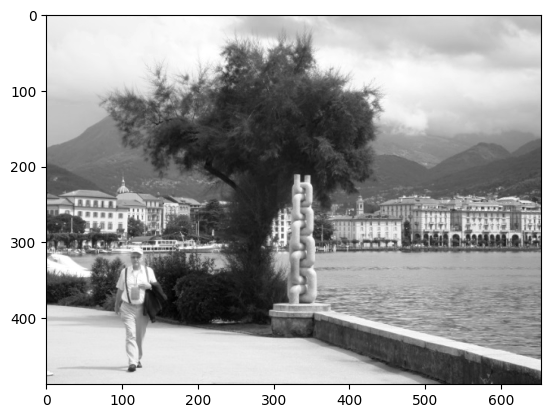

In [4]:
imgplot = plt.imshow(img, cmap='gray')

Построим сингулярное разложение этой матрицы.

In [5]:
from numpy.linalg import svd

U, S, VT = svd(img, full_matrices=False)

__[5 баллов] Задание 4.1__ Нарисуйте график диагональных элементов матрицы $\Sigma$:

In [7]:
fig = px.bar(x=range(len(S[:100])), y=S[:100])
fig.show()

Кажется, что они убывают достаточно быстро и есть надежда, что первые несколько компонент дадут картинку, близкую к исходной.

**Важно:** при визуализации различных компонент в этом задании используйте только матричные операции. В частности, избегайте циклов, функций `map` и `reduce`, а также специальных функций, находящих суммы компонент.

__[5 баллов] Задание 4.2__ Визуализуйте первую компоненту ранга 1. Ожидали ли Вы увидеть именно это? Поясните.

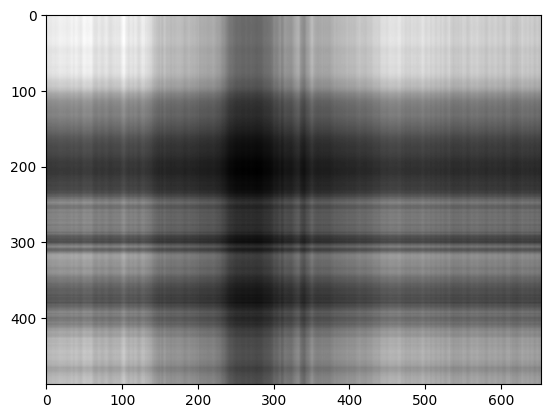

In [13]:
first_comp = U[:, :1] @ np.diag(S[:1]) @ VT[:1, :]
plt.imshow(first_comp,cmap="gray")

Первая компонента ранга 1 представляет собой одну из базовых форм, которые составляют изображение. Это может быть градиент, текстура или другой элемент изображения с высокой вариативностью или сильным вкладом в данные. В нашем случае заметны темные вертикальная и горизонтальная линии (это соответствует дереву и горам вдали).


__[5 баллов] Задание 4.3__  Визуализуйте суммы компонент ранга 1 с первой по двадцатую, с первой по пятидесятую, с двадцатой по сотую, с двадцатой по последнюю. Сделайте выводы.

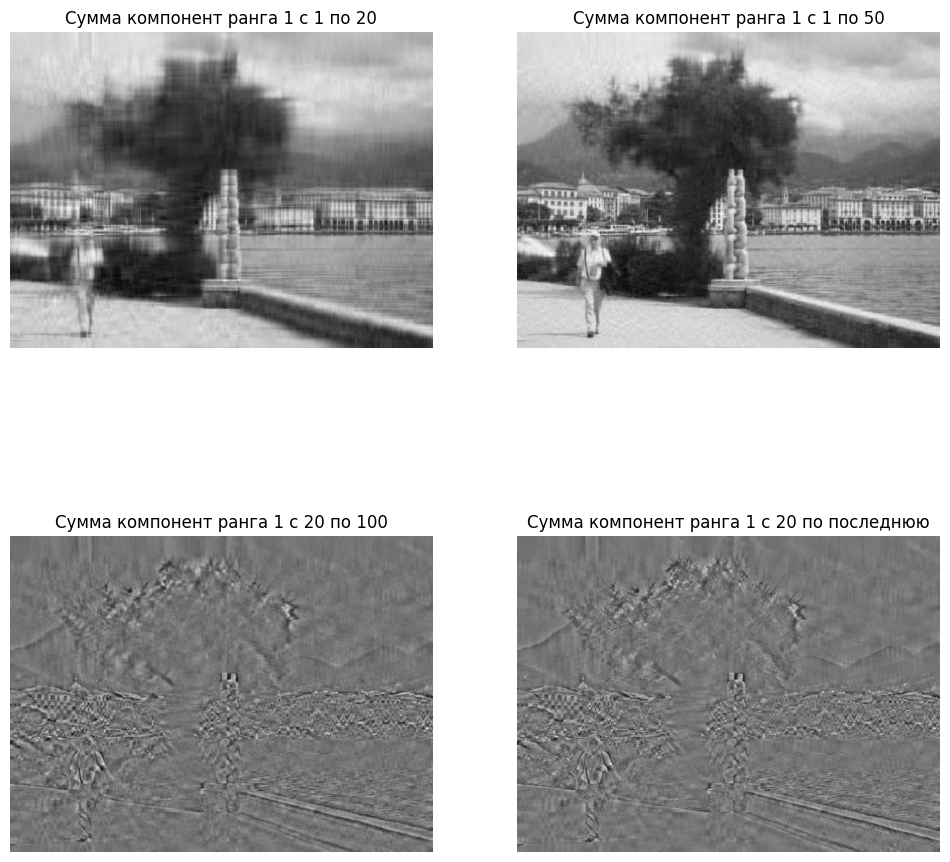

In [24]:
def plot_sum_components(U, S, VT, start, end, title, ax):
    # Вычисляем сумму компонент ранга 1
    sum_components = np.zeros_like(img)
    for i in range(start, end):
        sum_components += S[i] * np.outer(U[:, i], VT[i, :])
    
    # Визуализируем сумму компонент ранга 1
    ax.imshow(sum_components, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

# Создаем фигуру с 4 подграфиками
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Визуализируем суммы компонент ранга 1 с разными диапазонами
plot_sum_components(U, S, VT, 0, 20, "Сумма компонент ранга 1 с 1 по 20", axes[0, 0])
plot_sum_components(U, S, VT, 0, 50, "Сумма компонент ранга 1 с 1 по 50", axes[0, 1])
plot_sum_components(U, S, VT, 20, 100, "Сумма компонент ранга 1 с 20 по 100", axes[1, 0])
plot_sum_components(U, S, VT, 20, len(S), "Сумма компонент ранга 1 с 20 по последнюю", axes[1, 1])


Выводы:

* Сумма компонент ранга 1 с 1 по 20 показывает основные контуры и формы изображения, но с низким качеством и разрешением.

* Сумма компонент ранга 1 с 1 по 50 улучшает качество и разрешение изображения, но все еще оставляет много шума и артефактов.

* Сумма компонент ранга 1 с 20 по 100 добавляет больше деталей к изображению.

* Сумма компонент ранга 1 с 20 по последнюю добавляет еще больше деталей к изображению (границы объектов и тп), но в целом визуально не особо отличима от суммы первой компоненты с 20 по 100.

__[2 балла] Задание 4.4__  Как Вам кажется, какие компоненты нужно взять для достаточно хорошего восстановления исходного изображения? Аргументируйте свой ответ. Не забудьте визуализировать сумму выбранных компонент.

### А давайте глянем на дисперсию?

### Не забудьте визуализировать сумму выбранных компонент.

In [66]:
# Список, содержащий долю объясненной дисперсии для каждой компоненты
var_explained = np.round(S**2/np.sum(S**2), decimals=6)

print(f'variance Explained by Top 20 singular values:\n{var_explained[0:20]}')

fig = px.bar(x=list(range(1, 21)), y=var_explained[0:20])
fig.update_layout(title="Variance Explained Graph",
                  xaxis_title="Singular Vector",
                  yaxis_title="Variance Explained",
                  )
fig.show()

variance Explained by Top 20 singular values:
[9.08406e-01 4.04810e-02 1.53310e-02 5.74000e-03 5.45100e-03 3.64100e-03
 2.74500e-03 2.34100e-03 1.67100e-03 1.23100e-03 1.13300e-03 9.27000e-04
 8.58000e-04 7.06000e-04 6.41000e-04 5.78000e-04 4.13000e-04 3.66000e-04
 3.50000e-04 3.39000e-04]


#### Видно, что 1-ая копонента - решала 💪, 91% её!

In [67]:
cum_var_explained = np.cumsum(var_explained)
n_components = 20
fig = px.line(cum_var_explained[:100])
fig.add_vline(x=n_components, y0=0, y1=0.895, line_color='red')
fig.add_hline(y=0.9936, line_color='black')
fig.update_layout(title=f'Number of components needed to explain 99.37% variance: {n_components}', xaxis_title='Number of components', yaxis_title='Cumulative explained variance')
fig.show()

*Комментарий: для получения полного балла за это задания постарайтесь привести более убедительный аргумент, нежели Ваши субъективные впечатления от сравнения полученного изображения с исходным.*

> __Ответ:__ Глядя на полученный выше рисунок, можно сказать, что число компонент от 10 до 20 объясняет 99% дисперсии. Для выбора оптимального определния количества компонент можно использовать "метод локтя". На мой взгяд (с -5 диоптриями😄), точка, где происходит резких перегиб кривой лежит в районе от 15 до 25 компонент. Поэтому я взял середину - 20. Мой ответ 20 😌.



P.S. Эта сумма комонент уже была показана в упражнении 4.3.

__[2 балла] Задание 4.5__ Во сколько раз меньше памяти (теоретически) потребуется для хранения нового изображения по сравнению с исходным?

Как это посчитать?

### Использование SVD для сжатия изображений

Наше изображение представляет собой три цветовых канала: красный, зеленый и синий.

Каждый канал может быть представлен в виде (m × n)-матрицы со значениями от 0 до 255. Теперь сожмем матрицу A, представляющую один из каналов.
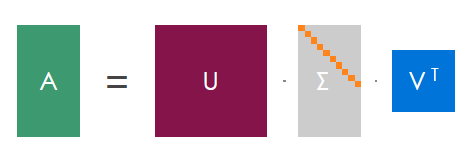


Для этого мы вычисляем SVD разложение матрицы A и выбираем k компоненет. В результате это будет занимать меньше места.

Факт дня: данные в матрицах $U$, $\Sigma$ и $V$ отсортированы по тому, насколько они вносят вклад в матрицу A.

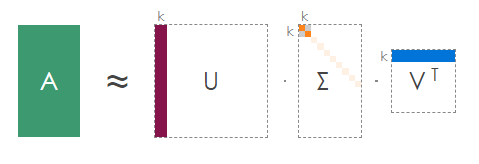

Объем данных, необходимых для хранения этой аппроксимации, пропорционален цветной области:

$$compressed \;size = m × k + k + k × n = k × (1 + m + n),$$

где m - число строк матрицы А, n - число столбцов матрицы А, k - количество выбранных компонент.

(На самом деле, из-за ортогональности U и V требуется немного меньше места.)

Источник: http://timbaumann.info/svd-image-compression-demo/


In [26]:
# Ранг исходной матрицы
np.linalg.matrix_rank(img)

488

> __Ответ:__ Из приведенных выкладок становится ясно, что все зависит от k. Изначально в наших данных было 488 компонент (см. размер матрицы). Размер без сжатия, пропорциональный количеству пикселей, т.е. в нашем случае:
$$488\cdot 653 = 318664.$$

Мы оставили лишь 20, поэтому теоретически нам потребуется $$compressed \;size = k × (1 + m + n) = 20\cdot (488+653+1) = 22840.$$

Отношение:$$\frac{318664}{22840} = 13.95$$

__[1 балл] Задание 4.6__ Подсчитайте, сколько в действительности места в памяти компьютера занимают исходная матрица и компоненты её сингулярного разложения. Согласуется ли этот результат с ответом предыдущего пункта? Сделайте выводы.

_Hint:_ достаточно сохранить два файла на компьютер в `.np` формате и сравнить их вес между собой.

In [27]:
np.save("img.npy", img)
np.save("U.npy", U[:, :20])
np.save("S.npy", np.diag(S[:20]))
np.save("V.npy", VT[:20, :])

In [28]:
size_img = os.path.getsize("img.npy")
size_U = os.path.getsize("U.npy")
size_S = os.path.getsize("S.npy")
size_V = os.path.getsize("V.npy")

In [29]:
print(f"Размер файла img.npy: {size_img} байт")
print(f"Размер файла U.npy: {size_U} байт")
print(f"Размер файла S.npy: {size_S} байт")
print(f"Размер файла V.npy: {size_V} байт")
print(f"Суммарный размер файлов U.npy, S.npy и V.npy: {size_U + size_S + size_V} байт")
print(f"Отношение размера файла img.npy к суммарного размера файлов U.npy, S.npy и V.npy: {size_img / (size_U + size_S + size_V)}")

Размер файла img.npy: 2549440 байт
Размер файла U.npy: 78208 байт
Размер файла S.npy: 3328 байт
Размер файла V.npy: 104608 байт
Суммарный размер файлов U.npy, S.npy и V.npy: 186144 байт
Отношение размера файла img.npy к суммарного размера файлов U.npy, S.npy и V.npy: 13.696063262850267


> __Ответ:__ 13.95 и 13.69 - вроде неплохо получилось👽. Результаты согласуются!

p.s. для совпадения размеров нужно теоретическое значение умножить на количество бит:

In [16]:
488*653*8

2549312

Сравним с реальным значением:

In [17]:
488*653*8 - 2549440

-128

Видим, что отличие всего лишь 128 бит. Видимо, они нужны для кодирования какой-то дополнительной информации.

## [20 баллов] Задача №5: Снижение размерности с помощью SVD

В этом задании вам предстоит работать с подмножеством датасета, повествующего о химическом составе воды в некоторых реках (источник датасета здесь: http://data.europa.eu/euodp/en/data/dataset/data_waterbase-rivers-10). Данные лежат в файле `dataset_final`.

Загрузим же его поскорей:

In [30]:
import pickle
index_list, feature_list, data_matrix = pickle.load(open('dataset_final', 'rb'))

In [31]:
A = data_matrix.copy()

Несколько слово о том, что это за три сущности:
* `index_list` - список id рек, которые были отобраны для задания (если вам захочется узнать, что именно скрывается за этими ужасными id, расшифровки есть в таблице `Waterbase_rivers_v14_Stations.csv`, которую мы для удобства загрузили на вики)
* `feature_list` - список признаков (они имеют вид `год ПРОБЕЛ показатель`)
* `data_matrix` - собственно данные (строки соответствуют рекам из `index_list`, а столбцы - признакам из `feature_list`)

Ваше первое задание - сделать так, чтобы отрисовка всех объектов в координатах первых двух "скрытых" признаков, полученных с помощью SVD, давала хорошую визуализацию датасета. Изначально к этому будут некоторого рода препятствия; мы ожидаем, что вы их устраните.

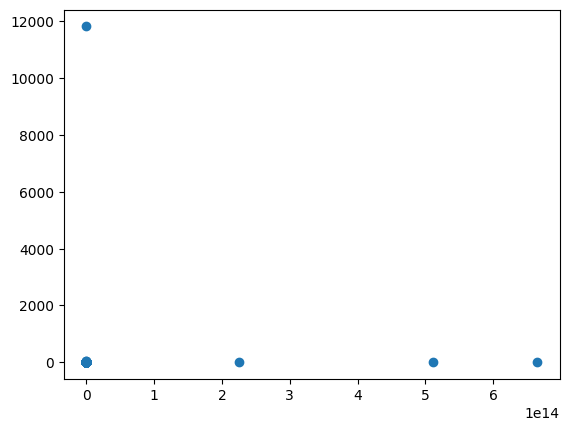

In [37]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10) 
A_svd = svd.fit_transform(A) 
plt.scatter(A_svd[:, 0], A_svd[:, 1])

Прямое применение SVD к данным не дало хорошегго результата.

- Вспомним, что SVD пытается выделять главные компоненты, максимизируя дисперсию. Дисперсия чувствительна к выбросам, значит и метод главных компонент чувствителен к ним.

- Судя по всемму у данных разные единицы измерения, значит разброс несопоставим. SVD запутался.

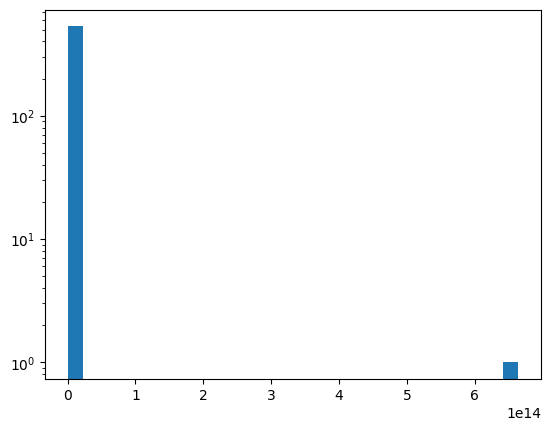

In [38]:
plt.hist(A.max(axis=0), bins=30,log=True);

Срежем выбросы по 99\% квантилю, а затем стандартизируем данные.

In [39]:
replace = np.percentile(A, 99, axis=0)
for i in range(A.shape[1]):
    A[:,i][A[:,i] > replace[i]] = replace[i]

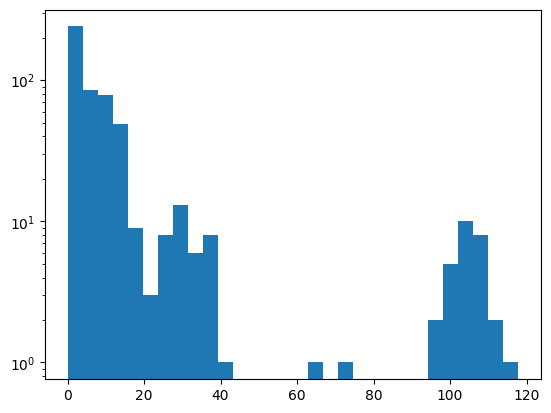

In [40]:
plt.hist(A.max(axis=0), bins=30,log=True);

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
A_scal = scaler.fit_transform(A)

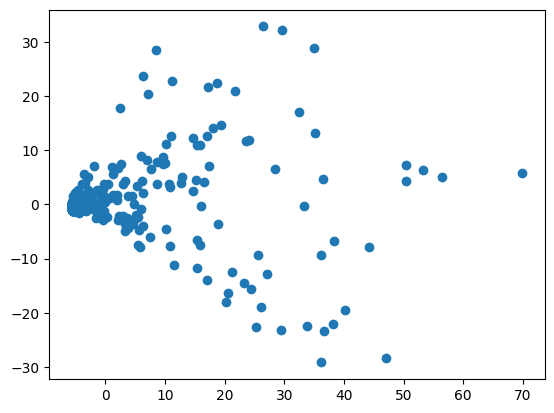

In [42]:
svd = TruncatedSVD(n_components=10) # Выбираем 10 компонент
A_svd = svd.fit_transform(A_scal) # Получаем матрицу с координатами объектов в двумерном пространстве
plt.scatter(A_svd[:, 0], A_svd[:, 1])

Визуализация стала лучше!

Сравните результаты с тем, что получилось бы, если воспользоваться [случайными гауссовскими проекциями](http://scikit-learn.org/stable/modules/random_projection.html). 

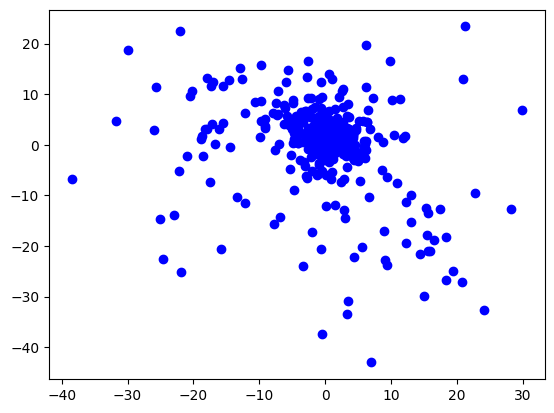

In [44]:
from sklearn import random_projection
np.random.seed(0)
transformer = random_projection.GaussianRandomProjection(n_components=10)
X_new = transformer.fit_transform(A_scal)
plt.scatter(X_new[:, 0], X_new[:, 1], c='b')

Попробуйте понять, какой физический смысл имеют первые три "скрытых" признака, полученных с помощью SVD.

Какие выводы о данных вы можете сделать из построенной визуализации?

Чтобы понять физический смысл первых признаков, посмотрим из каких колонок они формируются.

In [ ]:
sorted(list(zip(feature_list, np.abs(svd.components_[0]))), key = lambda w : w[1], reverse=True)[:10]

In [ ]:
sorted(list(zip(feature_list, np.abs(svd.components_[1]))), key = lambda w : w[1], reverse=True)[:10]

In [ ]:
sorted(list(zip(feature_list, np.abs(svd.components_[2]))), key = lambda w : w[1], reverse=True)[:10]

> __Ответ:__ Ваш ответ буквами прям в маркдауне:3

-----------   

# Часть 3: бонусные задания, чтобы намайнить баллов

Задачи из этого раздела необязательны для решения. Но мало ли вам захочется получить побольше баллов либо заменить какие-то скучные задачи из предыдущего раздела на нескучные.

## [20 баллов] Задача №6: SVD и свёртки

В компьютерном зрении важную роль играет операция свёртки. Вообще говоря, сворачивать приходится не только матрицы, но и более сложные тензоры, однако в этом задании мы для простоты будем работать только с матрицами.

В этом задании мы будем считать, что индексы элементов в матрицах нумеруются с нуля.

Пусть $B$ - матрица. *Свёртка* матрицы $A$ с ядром (или, как ещё говорят, с фильтром) $B$ - это матрица

$$(A * B)_{ij} = \sum_{p, q}a_{pq}b_{i - p, j - q}$$

Эту загадочную операцию можно проинтерпретировать следующим образом: для каждого элемента матрицы $A$ мы умножаем его "окрестность" (размеры этой окрестности зависят от размеров фильтра) поэлементно на соответствующие коэффициенты из ядра и всё это складываем:

<img src="http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png">

Таким образом, каждый элемент $A$ мы как-то обновляем с учётом его соседей. Скажем, свёртка с ядром

$$B = \frac19\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}$$

будет размывать изображение.

У вас может возникнуть вопрос: а что происходит на краях? Пусть $A$ - матрица $m\times n$, а $B$ - матрица $k\times l$. Есть разные варианты, например, такие:

- можно считать, что "за пределами" $A$ и $B$ тоже есть элементы, но просто они равны нулю; тогда результат свёртки будет иметь размер $(m + k - 1)\times(n + l - 1)$;
- можно точно так же считать, что элементы, лежащие "за пределами" $A$ и $B$ равны нулю, но законными считать только те компоненты свёртки, для которых "центр" фильтра попадает в матрицу $A$, тогда результат свёртки будет иметь такой же размер, как и $A$;
- можно считать законными только те компоненты свёртки, для которых фильтр целиком помещается "внутри" $A$; в этом случае результат свёртки будет меньшего размера, чем исходная матрица, а именно $(m - k + 1)\times(n - l + 1)$.

Дальше мы будем по умолчанию считать, что границы обрабатываются первым из указанных способов.

Свёртка называется *сепарабельной*, если она представляется в виде композиции свёрток

$$A * B = (A * U) * V,$$

где $U$ и $V$ - матрицы $(2t+1)\times1$ и $1\times(2s+1)$ (или $1\times(2s+1)$ и $(2t+1)\times1$).

__[4 балла] Задание 6.1__

Сверните фотографию с фильтром

$$B = \begin{pmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{pmatrix}$$

In [10]:
import cv2 as cv
from torch.nn.functional import conv2d, conv1d
img = cv.imread("chain_small.jpg")
img.shape

(488, 653, 3)

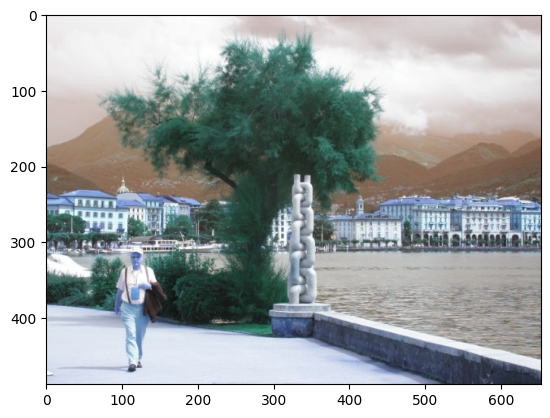

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline

imgplot = plt.imshow(img)

In [154]:
img_matrix = np.array(img)
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 488, 653])

In [155]:
filt = np.array([[-1,-1,-1],
                 [-1,8,-1],
                 [-1,-1,-1]])

kernel = np.array([[filt,filt,filt]])
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [156]:
# свернём картинку с подготовленным ядром свёртки
img_filt = conv2d(img_tensor, kernel)
img_filt = img_filt.permute(0, 2, 3, 1)
img_filt.size()

torch.Size([1, 486, 651, 1])

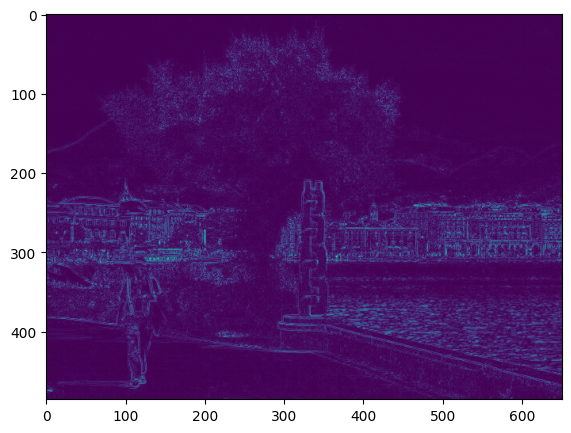

In [157]:
plt.figure(figsize=(10, 5))
plt.imshow(torch.abs(img_filt[0, :, :, 0]))
plt.show()

__[4 балла] Задание 6.2__ Проверьте, что операция свёртки (в которой границы обрабатываются первым из указанных способов!) ассоциативна, то есть

$$
(A * B) * C = A * (B * C)
$$

In [158]:
A = np.array([[-1,-1,-1],
              [-1,8,-1],
              [-1,-1,-1]])

B = np.array([[-1,-2,-1],
              [0, 0, 0],
              [1, 2, 1]])

C = np.array([[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]])

kernel1 = torch.tensor(np.array([[A, A, A]]), dtype=torch.float)
kernel2 = torch.tensor(np.array([[B]]), dtype=torch.float)
kernel3 = torch.tensor(np.array([[C]]), dtype=torch.float)

In [159]:
A = conv2d(img_tensor, kernel1)
AB = conv2d(A, kernel2)
ABC = conv2d(AB, kernel3)

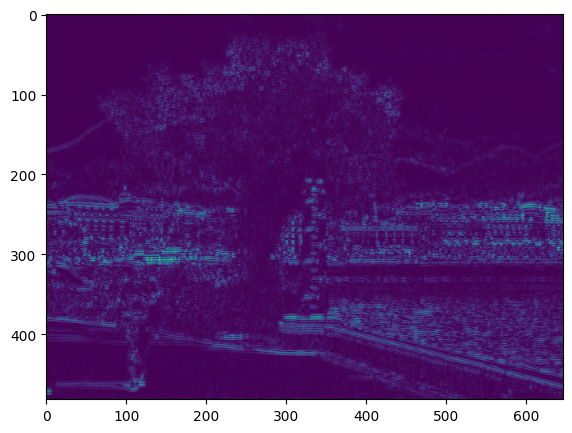

In [160]:
plt.figure(figsize=(10, 5))
plt.imshow(torch.abs(ABC[0, 0, :, :]))

In [161]:
A = np.array([[-1,-1,-1],
              [-1,8,-1],
              [-1,-1,-1]])

B = np.array([[-1,-2,-1],
              [0, 0, 0],
              [1, 2, 1]])

C = np.array([[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]])

kernel1 = torch.tensor(np.array([[A]]), dtype=torch.float)
kernel2 = torch.tensor(np.array([[B,B,B]]), dtype=torch.float)
kernel3 = torch.tensor(np.array([[C]]), dtype=torch.float)

In [162]:
B = conv2d(img_tensor, kernel2)
BC = conv2d(B, kernel3)
BCA = conv2d(BC, kernel1)

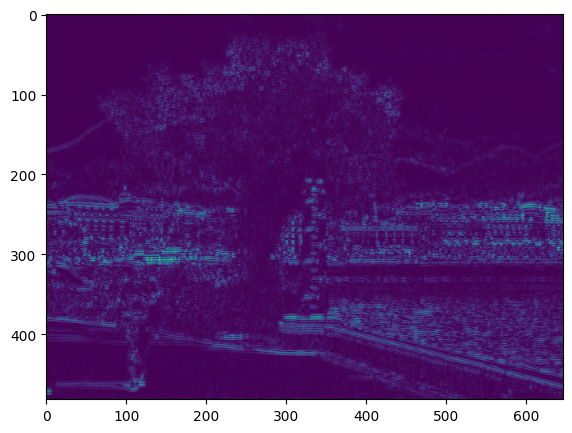

In [164]:
plt.figure(figsize=(10, 5))
plt.imshow(torch.abs(BCA[0, 0, :, :]))

In [165]:
np.allclose(ABC, BCA)

True

Видим, что матрицы совпадают:)

__[4 балла] Задание 6.3__ Убедитесь, что сепарабельную свёртку можно посчитать быстрее, чем не сепарабельную;

Если свёртка не является сепарабельной, нам нужно сделать $$O(h_{img} \cdot w_{img} \cdot h_K \cdot w_K )$$ операций. Если свёртка сепарабельная, её ядро можно представить в виде произведения двух векторов. То есть операция свёртки разбивается на две и осуществляется за $$O(h_{img} \cdot w_{img} \cdot h_K \cdot 1) + O(h_{img} \cdot w_{img} \cdot 1 \cdot w_K)$$ операций. Убедимся в том, что сепарабельная свёртка быстрее с помощью симуляций.

В качестве сепарабельного ядра возьмём


$$
K_1 = \frac19 \begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix} = \frac{1}{9} \cdot \begin{pmatrix}
1, 1, 1
\end{pmatrix} \cdot \begin{pmatrix}
1 \\
1 \\
1
\end{pmatrix}
$$

В качестве несепарабельной свёртки возьмём ядро для детектирования границы

$$K_2 = \begin{pmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{pmatrix}$$

In [29]:
sizes = np.arange(10, 1001, 10)

K1_row = np.ones(3) / 3
K1_col = np.ones(3) / 3

K2 = np.array([[-1, -1, -1],
                [-1, 8, -1],
                [-1, -1, -1]])

sep_times = []
nonsep_times = []
for size in tqdm(sizes): 
    # Генерируем случайное изображение 
    img = np.random.rand(size, size)
    sep_time = timeit(lambda: convolve1d(convolve1d(img, kernel_1_row, axis=1), kernel_1_col, axis=0), number=100)/100
    sep_times.append(sep_time)

    nonsep_time = timeit(lambda: convolve2d(img, kernel_2), number=100)/ 100
    nonsep_times.append(nonsep_time)
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=sizes, y=sep_times, mode='lines', name='Сепарабельное ядро')) 
fig.add_trace(go.Scatter(x=sizes, y=nonsep_times, mode='lines', name='Несепарабельное ядро'))
fig.update_layout(xaxis_title='Размер матрицы', yaxis_title='Время свертки (секунды)', title='Сравнение скорости свёртки для сепарабельного и несепарабельного ядер')
fig.show()

  0%|          | 0/100 [00:00<?, ?it/s]

__[4 балла] Задание 6.4__ Допустим, что вам нужно реализовать операцию свёртки с фильтром $B$, однако приоритетом для вас является скорее скорость, а не абсолютная точность, и поэтому вы готовы ценой не очень большой ошибки заменить исходную свёртку на какую-нибудь сепарабельную. Какую именно векторы $U$ и $V$ вы бы использовали в этом случае? Почему? Попробуйте оценить ошибку.

Можно сделать синуглаярное разложение и представить $B$ в виде $B=U\Sigma V^T$, где $U$ и $V^T$ — ортогональные матрицы, а $\Sigma$ — диагональная матрица с сингулярными значениями $B$ на диагонали. Тогда свёртка с фильтром $B$ эквивалентна последовательности свёрток с фильтрами $V$, $\Sigma$ и $U$.

In [90]:
from numpy.linalg import norm

B = torch.tensor([[-1, -1, -1],
                [-1, 8, -1],
                [-1, -1, -1]])

U, S, VT = sla.svd(B)
u= U[:,0]
v = S[0] * VT[0,:]

Y1 = convolve2d(img[:,:,0], B, mode='same')
Y2 = convolve1d(convolve1d(img[:,:,0], u, axis=0, mode='constant'), v, axis=1, mode='constant')

error = norm(Y1 - Y2)
print(f'Ошибка сепарабельной свёртки: {error:.4f}')

Ошибка сепарабельной свёртки: 91739.4947


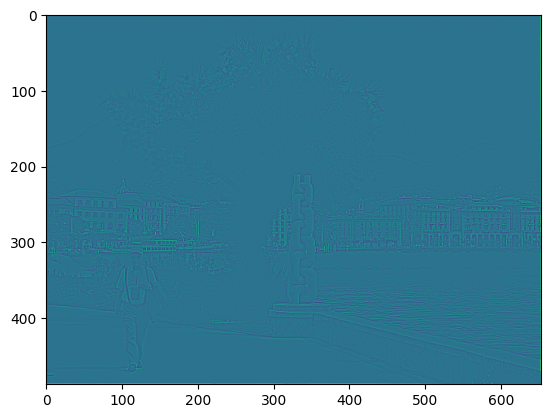

In [91]:
imgplot = plt.imshow(Y1)

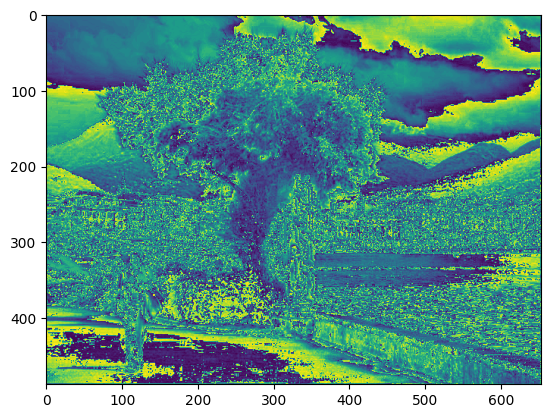

In [92]:
imgplot = plt.imshow(Y2)

__[4 балла] Задание 6.5__ Докажите, что любую свёртку можно выполнить, используя лишь операции свёртки с векторами (векторами-строками и/или векторами-столбцами) и операцию сложения.

In [289]:
# Создаем два двумерных тензора размера 3x3
A = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B = torch.tensor([[9, 8, 7], [6, 5, 4], [3, 2, 1]])
# Разложим тензор A на сумму трех векторов-строк
A1 = torch.tensor([[1, 2, 3], [0, 0, 0], [0, 0, 0]])
A2 = torch.tensor([[0, 0, 0], [4, 5, 6], [0, 0, 0]])
A3 = torch.tensor([[0, 0, 0], [0, 0, 0], [7, 8, 9]])
# Разложим тензор B на сумму трех векторов-столбцов
B1 = torch.tensor([[9, 0, 0], [6, 0, 0], [3, 0, 0]])
B2 = torch.tensor([[0, 8, 0], [0, 5, 0], [0, 2, 0]])
B3 = torch.tensor([[0, 0, 7], [0, 0, 4], [0, 0, 1]])
# Выполним свертку каждого вектора-строки из A с каждым вектором-столбцом из B
C11 = conv1d(A1.view(1, 1, -1), B1.view(1, 1, -1))
C12 = conv1d(A1.view(1, 1, -1), B2.view(1, 1, -1))
C13 = conv1d(A1.view(1, 1, -1), B3.view(1, 1, -1))
C21 = conv1d(A2.view(1, 1, -1), B1.view(1, 1, -1))
C22 = conv1d(A2.view(1, 1, -1), B2.view(1, 1, -1))
C23 = conv1d(A2.view(1, 1, -1), B3.view(1, 1, -1))
C31 = conv1d(A3.view(1, 1, -1), B1.view(1, 1, -1))
C32 = conv1d(A3.view(1, 1, -1), B2.view(1, 1, -1))
C33 = conv1d(A3.view(1, 1, -1), B3.view(1, 1, -1))
# Сложим все полученные свертки, чтобы получить итоговую свертку A и B
C = C11 + C12 + C13 + C21 + C22 + C23 + C31 + C32 + C33
C

tensor([[[165]]])

In [290]:
# Сравним с двумерной сверткой
conv2d(A.view(1, 1, 3, 3), B.view(1, 1, 3, 3))

tensor([[[[165]]]])

Получили одинаковый результат:)

## [10 баллов] Задача №7: Неожиданно теоретическая задача

Для двух заданных матриц $A$ и $B$ одного размера найдите ортогональную матрицу $Q$, для которой норма Фробениуса разности $||QA - B||_F$ минимальна.

> __Ответ:__ Мы знаем, что $$||B||_F = \sqrt{tr(C^*C)}$$

То есть нам надо минимизировать такую штуку: $$\min tr[(Q^*A^* - B^*)(QA - B)] = \min tr(Q^*A^*QA - Q^*A^*B -B^*QA + B^*B)$$

Предполагаю, что мы рассматриваем вещественные матрицы, тогда $B^*=B^T$, $A^*=A^T$, $Q^*=Q^T$.

То есть мы получаем:

$$\min tr(Q^TA^TQA - Q^TA^TB -B^TQA + B^TB) = \min tr(A^TA - Q^TA^TB -B^TQA + B^TB)$$

Первый и последний слагаемые $>0$.

Для минимизации нашего выражения там необходимо максимизировать слагаемое $$\max tr(Q^TA^TB + B^TQA) = \max tr(Q^TA^TB + A^TQ^TB) = \max tr(Q^TA^TB + Q^TA^TB) = \max 2tr(Q^TA^TB)$$

Пришло время SVD!

Пусть $A^TB = Z$

Тогда можем разложить $$tr(Q^TZ) = tr(Q^TU\Sigma V^T)$$

Надо найти матрицу Q, которая максимизирует $tr(Q^T U \Sigma V^T)$. Для этого мы хотим, чтобы скалярные произведения строк U \Sigma V^T и столбцов Q были как можно больше. Поскольку строки $U \Sigma V^T$ образуют ортонормированный базис, то максимальное скалярное произведение с любым вектором достигается, когда этот вектор совпадает с одной из строк. Аналогично, поскольку столбцы $Q$ образуют ортонормированный базис, то максимальное скалярное произведение с любым вектором достигается, когда этот вектор совпадает с одним из столбцов. Таким образом, мы хотим, чтобы $Q$ была такой матрицей, что $Q^T U \Sigma V^T$ была бы диагональной матрицей с максимальными возможными элементами на диагонали.

Один из способов сделать это — взять $Q^T = VU^T$. Тогда $$Q^T U \Sigma V^T = VU^T U \Sigma V^T = \Sigma,$$ 

Тогда $tr(Q^T U \Sigma V^T) = tr(\Sigma)$. 

Решение по мотивам: https://math.stackexchange.com/questions/754301/find-the-maximum-of-operatornametrrz-over-all-orthogonal-matrices-r